In [0]:
# General imports
import string
import numpy as np
import pandas as pd
import sklearn.feature_extraction as skprep
from sklearn.metrics import roc_curve, auc
from itertools import compress
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(20190124)
%matplotlib inline

# Keras imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Reshape, MaxPooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import seaborn as sns
import numpy as np
import string
import pickle
import codecs
import fileinput
import os
import re
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


In [0]:
## download fasttext library and make
!wget https://github.com/facebookresearch/fastText/archive/v0.9.1.zip 
!unzip v0.9.1.zip
%cd fastText-0.9.1
!make
# download the embedding vectors. use 2 million word vectors trained with subword information on Common Crawl (600B tokens).
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
!unzip crawl-300d-2M-subword.zip
!wget --no-check-certificate --output-document=data.zip 'https://drive.google.com/uc?export=download&id=1bsOWcjQFCylShsMslVtso6WDL2nquaPJ'
!unzip data.zip

--2019-12-16 00:54:00--  https://github.com/facebookresearch/fastText/archive/v0.9.1.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/v0.9.1 [following]
--2019-12-16 00:54:00--  https://codeload.github.com/facebookresearch/fastText/zip/v0.9.1
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.1.zip’

v0.9.1.zip              [  <=>               ]   4.13M  15.7MB/s    in 0.3s    

2019-12-16 00:54:00 (15.7 MB/s) - ‘v0.9.1.zip’ saved [4327207]

Archive:  v0.9.1.zip
b5b7d307274ce00ef52198fbc692ed3bd11d9856
   creating: fastText-0.9.1/
   creating: fastText-0.9.1/.circleci/
  inflating: fastText-0

In [0]:
df = pd.read_csv("Full_Data.csv",encoding='iso-8859-1')
df.head()

,text,sentiment,confidence
0,trying to wait a patient as i can lol,1,0.3
1,"Good morning Fotopro Team, I noticed in some ...",1,0.6
2,these still on track? ahead? behind?,1,0.2
3,any update on delivery?,1,0.0
4,product so nice had to get it twice,1,0.5


In [0]:
# text cleaning for fasttext embedding: only remove punctuations because fasttext doesn't include punctuations.
# Collect punctuation signs.
table = str.maketrans(' ', ' ', string.punctuation)
# Remove them from the text
df.iloc[:,0] = [j.translate(table) for j in df.iloc[:,0]]
df.iloc[:,0] = [j.replace('\x96',' ') for j in df.iloc[:,0]]
# Eliminate double spaces
df.iloc[:,0] = [" ".join(j.split()) for j in df.iloc[:,0]]

In [0]:
# check percentage of stopwords
# stop words include a,the,be. Doesn't contain much information.
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
df['word_count']=df['text'].apply(lambda x:len(x.split()))
df['stopwords_percent'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))/df['word_count']
df[['text','stopwords_percent']].head(10)
# could see high percentage of stopwords in text. will remove them

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,stopwords_percent
0,trying to wait a patient as i can lol,0.555556
1,Good morning Fotopro Team I noticed in some of...,0.470588
2,these still on track ahead behind,0.333333
3,any update on delivery,0.500000
4,product so nice had to get it twice,0.500000
5,Just curious Will you have any extension goals...,0.523810
6,Got hands on this kit at the photoshow Birming...,0.428571
7,looking forward to the many uses of this produ...,0.545455
8,Hi Looking forward to getting this product Wha...,0.384615
9,Weâll post an update in the afternoon tomorr...,0.333333


In [0]:
# convert to lower case
# replace contraction
def replace_contraction(string):
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                        "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                        "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                        "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                        "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                        "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                        "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                        "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
                        "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                        "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                        "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
                        "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                        "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                        "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                        "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", 
                        "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
                        "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                        "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", 
                        "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                        "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
                        "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", 
                        "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                        "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                        "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                        "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                        "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                        "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", 
                        "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    word_list = string.split()
    for index,word in enumerate(word_list):
        if word in contraction_dict.keys():
            word_list[index] = contraction_dict[word]
    new_string = ' '.join(word_list)
    return new_string
# remove \r and \n
# remove weblinks
# remove numbers
# remove stopwords
def remove_stop(s):
  words=s.split()
  lst=[]
  for w in words:
    if w not in stop:
      lst.append(w)
  return ' '.join(lst)
# remove emoji
def remove_emoji(s):
  return s.encode('ascii', 'ignore').decode('ascii')

def cleantext(s):
  # convert to lower case
  s=s.lower()
  # replace contraction
  s=replace_contraction(s)
  # remove \r and \n
  s=s.replace("\r",'')
  s=s.replace("\n",'')
  # remove numbers
  s=re.sub(r'\d+','',s)
  # remove weblinks
  s=re.sub(r"http\S+", "",s)
  # remove stopwords
  s=remove_stop(s)
  # remove emoji
  s=remove_emoji(s)
  return s
# rigorous data cleaning for glove embedding.
df['clean']=df['text'].apply(cleantext)

In [0]:
# compare original text and cleaned text
df[['text','clean']].head()

,text,clean
0,trying to wait a patient as i can lol,trying wait patient lol
1,Good morning Fotopro Team I noticed in some of...,good morning fotopro team noticed comments wou...
2,these still on track ahead behind,still track ahead behind
3,any update on delivery,update delivery
4,product so nice had to get it twice,product nice get twice


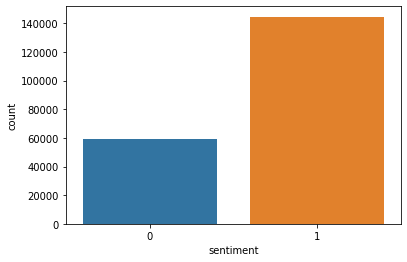

In [0]:
## Q2 exploratory data analysis
# distribution of comments
sns.countplot(df.sentiment)
# around 60000 negative and 140000 positive comments

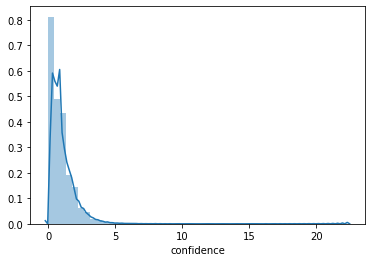

In [0]:
sns.distplot(df['confidence'])

In [0]:
# how many tokens before cleaning
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
Vals = list(tokenizer.word_index.keys())
len(Vals)
# 113219 words appeared in the comments. There are 171476 words in current use according to Oxford dictionary.

113219

In [0]:
# number of tokens after cleaning
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean'])
Vals = list(tokenizer.word_index.keys())
len(Vals)
# 92763 tokens after cleaning

92763

In [0]:
word_dictionary = pd.DataFrame(tokenizer.word_counts,columns=tokenizer.word_counts.keys(),index=[0])
word_dictionary = word_dictionary.T.reset_index()
word_dictionary.columns=['word','count']

In [0]:
# see what are the most frequent words
word_dictionary.sort_index(by='count',ascending=False)[:20]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


,word,count
17,the,285387
1,to,188774
6,i,162364
87,and,133487
3,a,123695
20,you,107691
59,for,87643
51,it,86135
16,of,80458
30,is,80209


In [0]:
frequency_top200= sum(word_dictionary.sort_index(by='count',ascending=False)[:20]['count'])
frequency_top200/sum(word_dictionary['count'])
# top 200 most frequent words contitute 40.17% of all words shown up
# top 20 most frequent words contitute 10.8% of all words shown up

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


0.1083305681086719

In [0]:
# Write CSV with the output.
file = codecs.open('Words_In_Comments.csv', "w", "utf-8")
for item in Vals:
    file.write("%s\r\n" % item)
file.close()

In [0]:
!./fasttext print-sentence-vectors crawl-300d-2M-subword.bin < Words_In_Comments.csv > EmbeddingComments_fasttext.tsv

tcmalloc: large alloc 4800004096 bytes == 0x56390c552000 @  0x7efe36aad887 0x5638f93998cf 0x5638f93a43e4 0x5638f93a4ed1 0x5638f93b0873 0x5638f937bef8 0x7efe35b4ab97 0x5638f937bf8a
tcmalloc: large alloc 2400002048 bytes == 0x563a2a6f6000 @  0x7efe36aad887 0x5638f93998cf 0x5638f93a4428 0x5638f93a4ed1 0x5638f93b0873 0x5638f937bef8 0x7efe35b4ab97 0x5638f937bf8a


In [0]:
with fileinput.FileInput('EmbeddingComments_fasttext.tsv', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(' ', ','), end='')
        import numpy as np
# Create the first line to make it easy to read back
firstLine = ','.join(['D'+str(i) for i in np.arange(1, 301)]) + '\n'
# Open as read only. Read the file
with open('EmbeddingComments_fasttext.tsv', 'r') as original: 
  data = original.read()
# Open to write and write the first line and the rest
with open('EmbeddingComments_fasttext.csv', 'w') as modified: 
  modified.write(firstLine + data)

!head EmbeddingComments_fasttext.csv

D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D50,D51,D52,D53,D54,D55,D56,D57,D58,D59,D60,D61,D62,D63,D64,D65,D66,D67,D68,D69,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99,D100,D101,D102,D103,D104,D105,D106,D107,D108,D109,D110,D111,D112,D113,D114,D115,D116,D117,D118,D119,D120,D121,D122,D123,D124,D125,D126,D127,D128,D129,D130,D131,D132,D133,D134,D135,D136,D137,D138,D139,D140,D141,D142,D143,D144,D145,D146,D147,D148,D149,D150,D151,D152,D153,D154,D155,D156,D157,D158,D159,D160,D161,D162,D163,D164,D165,D166,D167,D168,D169,D170,D171,D172,D173,D174,D175,D176,D177,D178,D179,D180,D181,D182,D183,D184,D185,D186,D187,D188,D189,D190,D191,D192,D193,D194,D195,D196,D197,D198,D199,D200,D201,D202,D203,D204,D205,D206,D207,D208,D209,D210,D211,D212,D213,D214,D215,D216,D217,D218,D219,D220,D221,D22

In [0]:
# Read word embeddings
Embeddings = pd.read_csv('EmbeddingComments_fasttext.csv', sep=',', decimal = '.', low_memory = True, index_col = False)
Embeddings.shape

(113219, 300)

Avg. no of words: 30.26
Std. deviation: 28.62
Max words: 1257


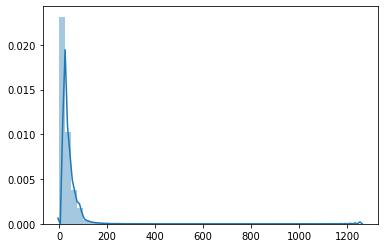

In [0]:
# Create embedding dictionary
EmbeddingsDict = dict(zip(Vals, Embeddings.values))
%matplotlib inline
# Count maximum number of words per comment.
wordDist = [len(w.split()) for w in df.iloc[:,0]]
print('Avg. no of words: ' + str(np.round(np.mean(wordDist), 2)))
print('Std. deviation: ' + str(np.round(np.std(wordDist), 2)))
print('Max words: ' + str(np.max(wordDist)))
# Generate the plot
distComments = sns.distplot(wordDist)
## I will use 150 words as maximum sequence length

In [0]:
## create input layer: the embedding of each word
# Create word index from input
sequences = tokenizer.texts_to_sequences(df['text']) # Create the sequences.
# Creates the training dataset, adding padding when necessary.
data = pad_sequences(sequences, maxlen=150, padding = 'post') 
# Creates the objective function
labels = df['sentiment'] # the sentiment
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (204058, 150)
Shape of label tensor: (204058,)


In [0]:
word_index=tokenizer.word_index
embedding_matrix = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    embedding_vector = EmbeddingsDict.get(word)
    if (embedding_vector is not None) and (i<len(word_index)):
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(113220, 300)

In [0]:
np.savetxt("a3_fasttext_EmbeddingMatrix.txt", embedding_matrix)

In [0]:
# We will also save the word dictionary as pkl
f = open("WordDictionary.pkl","wb")
pickle.dump(word_index, f)
f.close()

In [0]:
!mkdir a3_fasttext_Preprocessed
# Save outputs
np.savetxt("a3_fasttext_Preprocessed/Comment_Padded.txt", data)
np.savetxt("a3_fasttext_Preprocessed/Comment_Labels.txt", labels)

In [0]:
!mv a3_fasttext_EmbeddingMatrix.txt a3_fasttext_Preprocessed

In [0]:
!mv WordDictionary.pkl a3_fasttext_Preprocessed

In [0]:
# Zip all files for download.
!zip -r a3_fasttext_Preprocessed.zip a3_fasttext_Preprocessed
from google.colab import files

  adding: a3_fasttext_Preprocessed/ (stored 0%)
  adding: a3_fasttext_Preprocessed/Comment_Labels.txt (deflated 99%)
  adding: a3_fasttext_Preprocessed/a3_fasttext_EmbeddingMatrix.txt (deflated 75%)
  adding: a3_fasttext_Preprocessed/Comment_Padded.txt (deflated 98%)


In [0]:
files.download("a3_fasttext_Preprocessed.zip")

KeyboardInterrupt: ignored

## restore the embedding matrix, data and label

In [0]:
labels.shape

(204058,)

In [0]:
###  NEED TO DOWNLOAD AND UPLOAD DATA AGAIN 
# embedding
!gdown "https://drive.google.com/uc?id=1dkKJbreCMckEBOJz4swQtOKJsBIyZJ9W"
# labels
!gdown "https://drive.google.com/uc?id=1_NEpj1PPr8pfVOAjBdWiUcvWeQ5oXk_C"
# data
!gdown "https://drive.google.com/open?id=1S0o81ReH644OdRTJ8c2SzA4-X7sY7S2x"


Downloading...
From: https://drive.google.com/uc?id=1dkKJbreCMckEBOJz4swQtOKJsBIyZJ9W
To: /content/a3_fasttext_EmbeddingMatrix.txt
425MB [00:03, 128MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1_NEpj1PPr8pfVOAjBdWiUcvWeQ5oXk_C
To: /content/Comment_Labels.txt
3.27MB [00:00, 104MB/s]
/usr/local/lib/python2.7/dist-packages/gdown/parse_url.py:31: UserWarning: You specified Google Drive Link but it is not the correct link to download the file. Maybe you should try: https://drive.google.com/uc?id=1S0o81ReH644OdRTJ8c2SzA4-X7sY7S2x
  .format(url='https://drive.google.com/uc?id={}'.format(file_id))
Downloading...
From: https://drive.google.com/open?id=1S0o81ReH644OdRTJ8c2SzA4-X7sY7S2x
To: /content/open?id=1S0o81ReH644OdRTJ8c2SzA4-X7sY7S2x
69.3kB [00:00, 4.44MB/s]


In [0]:
embedding_matrix=np.genfromtxt("a3_fasttext_EmbeddingMatrix.txt")
#data=np.genfromtxt("Comment_Padded.txt")
labels=np.genfromtxt("Comment_Labels.txt")

In [0]:
embedding_matrix.shape

(55526, 300)

In [0]:
#print(embedding_matrix.shape)
print(data.shape)
#print(labels.shape)

(204058, 150)


In [0]:
data[1]

array([   84,   802, 46758,   148,     3,   784,    11,    68,     9,
           1,   261,   557,     6,    36,    18,  1374,   262,   371,
          11,   571,    57,   571,   653,    62,    10,    49,    34,
          44,    15,    46,    17,    26,   296,   356,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [0]:
confidence = df['confidence']
X_train, X_test, y_train, y_test,X_confidence,y_confidence=train_test_split(data, labels, confidence,test_size=0.33,random_state=1,stratify = labels)

### build model:sequential convnet
* A embedding layer
* A 1D convolution of size 3 (so three word sequences)
* A second 1D convolution of size 3 (so more complex word sequences)
* Dropout to avoid overfitting
* Max pooling to get the most important sequences.

* A flattening layer.
* A dense layer of 128 neurons.
* Dropout with p = 0.5
* A softmax output

In [0]:
seq_model = Sequential()
embedding_layer = Embedding(embedding_matrix.shape[0], 300,weights=[embedding_matrix],input_length=150,trainable=False)            

seq_model.add(embedding_layer)
seq_model.add(Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu',strides=1))
#seq_model.add(Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu',strides=1))
seq_model.add(Dropout(0.5))
seq_model.add(MaxPooling1D(pool_size = 3))
#seq_model.add(Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu',strides=1))
#seq_model.add(Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu',strides=1))
#seq_model.add(Dropout(0.5))
#seq_model.add(MaxPooling1D(pool_size = 3))
# Turn output matrices into 1D tensor for shallow network.
seq_model.add(Flatten())
seq_model.add(Dense(128, activation = 'relu'))
seq_model.add(Dropout(0.5))
seq_model.add(Dense(1, activation = 'sigmoid'))
seq_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 300)          33966000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 148, 128)          115328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 148, 128)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 49, 128)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               802944    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [0]:
from keras.utils import plot_model
plot_model(seq_model, show_shapes=True, show_layer_names=True, to_file='seq_model.png')
Image(retina=True, filename='seq_model.png')

Train on 91601 samples, validate on 45117 samples
Epoch 1/20
91601/91601 [==============================] - 22s 240us/sample - loss: 0.3737 - acc: 0.8310 - val_loss: 0.3393 - val_acc: 0.8490
Epoch 2/20
91601/91601 [==============================] - 22s 239us/sample - loss: 0.3330 - acc: 0.8520 - val_loss: 0.3161 - val_acc: 0.8590
Epoch 3/20
91601/91601 [==============================] - 22s 236us/sample - loss: 0.3186 - acc: 0.8587 - val_loss: 0.3135 - val_acc: 0.8620
Epoch 4/20
91601/91601 [==============================] - 21s 233us/sample - loss: 0.3086 - acc: 0.8627 - val_loss: 0.3295 - val_acc: 0.8523
Epoch 5/20
91601/91601 [==============================] - 21s 234us/sample - loss: 0.2989 - acc: 0.8686 - val_loss: 0.3108 - val_acc: 0.8633
Epoch 6/20
91601/91601 [==============================] - 21s 233us/sample - loss: 0.2900 - acc: 0.8729 - val_loss: 0.3242 - val_acc: 0.8568
Epoch 7/20
91601/91601 [==============================] - 22s 240us/sample - loss: 0.2807 - acc: 0.8766 

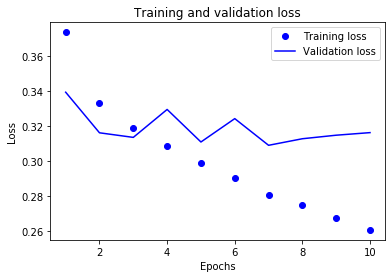

In [0]:
# Use Adam as optimizer, with a binary_crossentropy error.
seq_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
callbacks_list=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),keras.callbacks.ModelCheckpoint(filepath='seq_model.h5',monitor='val_loss',save_best_only=True)]
history = seq_model.fit(X_train, y_train, validation_split=0.33, epochs=20, batch_size=20,callbacks=callbacks_list)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

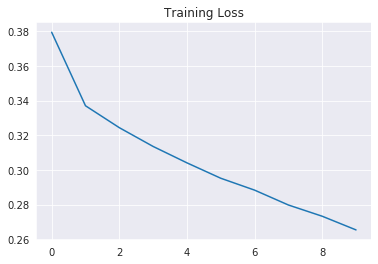

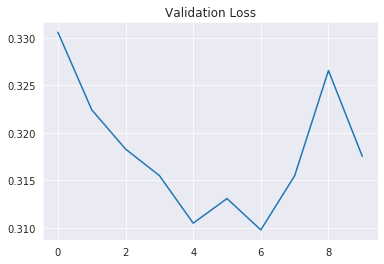

In [0]:
sns.set_style("darkgrid")
plt.plot(seq_model.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(seq_model.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

In [0]:
## draw roc auc here
# Calculate outputs in test set
seq_model.load_weights("seq_model.h5")
seq_prob_test = seq_model.predict(X_test, verbose = 1)
seq_prob_train = seq_model.predict(X_train, verbose = 1)


136718/136718 [==============================] - 6s 46us/sample


In [0]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_train, seq_prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, seq_prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)


AUC train:  0.9504462689574837
AUC test:  0.9260517753457541


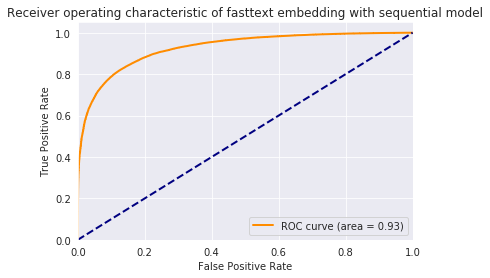

In [0]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of fasttext embedding with sequential model')
plt.legend(loc="lower right")
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
seq_class_test = seq_model.predict_classes(X_test)
conf=confusion_matrix(y_test, seq_class_test)
conf

array([[14714,  4884],
       [ 4379, 43363]])

In [0]:
def calc_metrics(conf):
  tn=conf[0][0]
  tp=conf[1][1]
  fn=conf[1][0]
  fp=conf[0][1]

  acc= (tn+tp)/(tn+tp+fn+fp)
  recall = tp/(tp+fn)
  sensitivity = tn/(tn+fp)
  precision = tp/(tp+fp)
  f1 = 2*precision*recall/(precision+recall)

  print("accuracy:{},recall:{},sensitivity:{},precision:{},f1:{}".format(acc,recall,sensitivity,precision,f1))
calc_metrics(conf)

accuracy:0.8624443124443124,recall:0.9082778266515856,sensitivity:0.7507908970303092,precision:0.8987709080357328,f1:0.9034993593015865


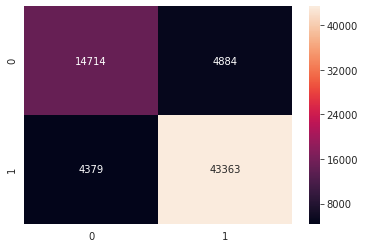

In [0]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, seq_class_test))
sns.heatmap(conf_mat,annot=True,fmt='d')

## parallel model
* An embedding layer, just like before.
* A parallel model of 5 layers, each consisting of:
* * A Conv1D layer with kernel sizes [2, 3, 5, 8,10], with 128 filters
** A max pooling layer of size Embedding Dimension - Filter Size + 1. 
** A flattening layer to turn this into a vector.
* A dense layer of size 128.
* Dropout with probability 0.5.
* An output layer of size 1.

Model: "parallelModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 149, 128)     76928       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 148, 128)     115328      input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 146, 128)     192128      input_2[0][0]                    
______________________________________________________________________________________

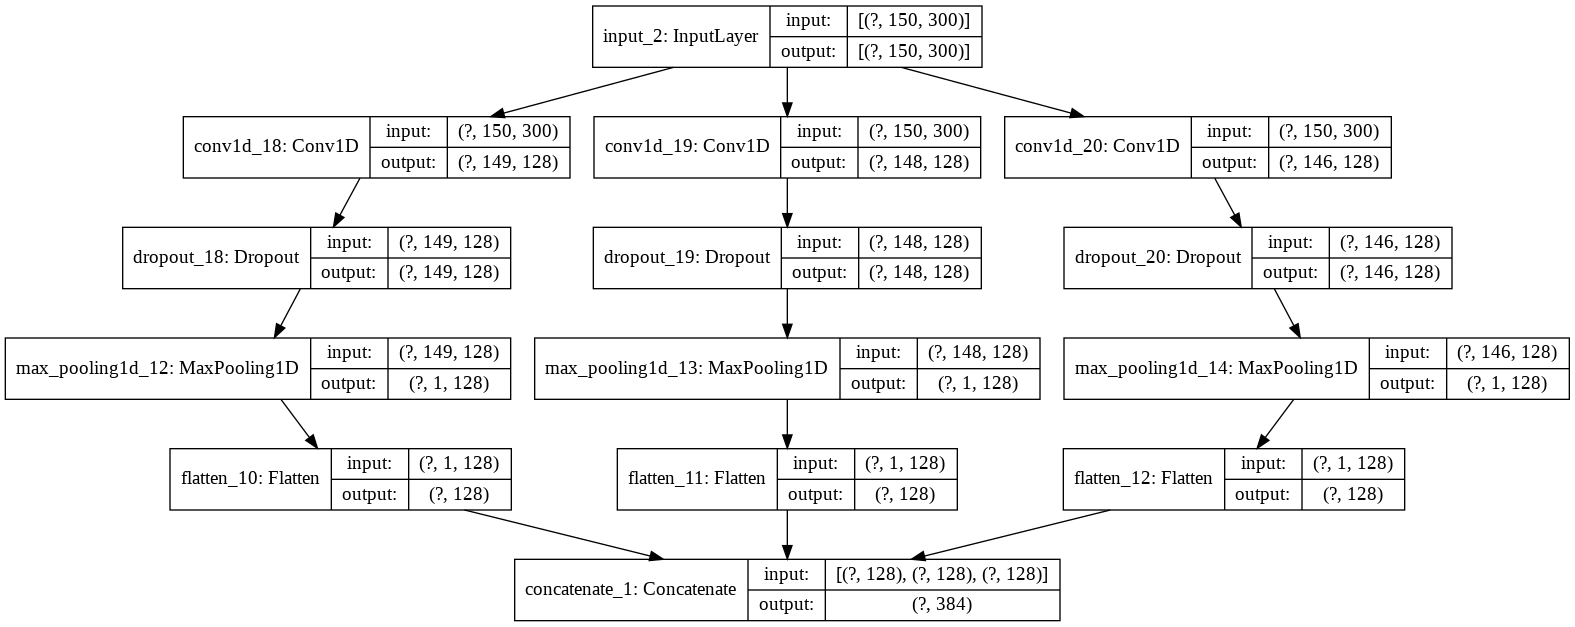

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
%matplotlib inline
filter_sizes = (2,3,5)
graph_in = Input(shape=(150, 300))
convs = []
avgs = []
# since there are more layers,a drop out is added
for fsz in filter_sizes:
    conv = Conv1D(filters=128,kernel_size=fsz,padding='valid',activation='relu',strides=1)(graph_in) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
    drop = Dropout(0.4)(conv)
    pool = MaxPooling1D(pool_size=150 - fsz + 1)(drop) # Put this layer AFTER the convolution just created.
    flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs.append(flattenMax)
# Concatenate layers.
if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]
paral = Model(inputs=graph_in, outputs=out, name="parallelModel")
paral.summary()
plot_model(paral, show_shapes=True, show_layer_names=True, to_file='paral.png')
Image(retina=True, filename='paral.png')

In [0]:
## add the middle layers to a traditional sequential model
paral_model = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=150,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

paral_model.add(embedding_layer)

# Now we add our graph model
paral_model.add(paral)

# Add a few layers
paral_model.add(Dense(128, activation='relu'))
paral_model.add(Dropout(0.5))
paral_model.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
paral_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
paral_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 300)          33966000  
_________________________________________________________________
parallelModel (Model)        (None, 384)               384384    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               49280     
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 34,399,793
Trainable params: 433,793
Non-trainable params: 33,966,000
_________________________________________________________________


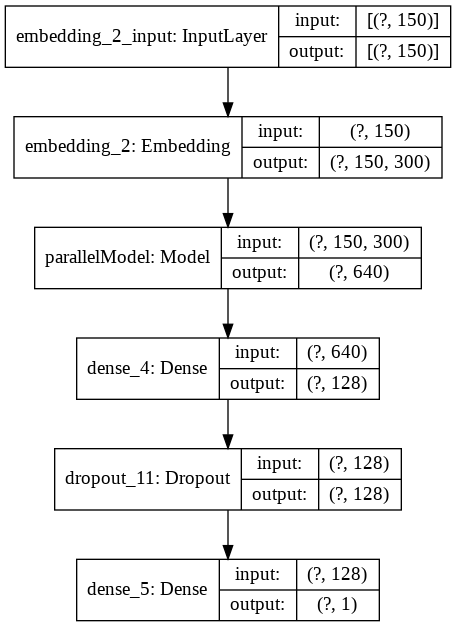

In [0]:
plot_model(paral_model, show_shapes=True, show_layer_names=True, to_file='paral_model.png')
Image(retina=True, filename='paral_model.png')

Train on 91601 samples, validate on 45117 samples
Epoch 1/20
91601/91601 [==============================] - 36s 392us/sample - loss: 0.3535 - acc: 0.8391 - val_loss: 0.3228 - val_acc: 0.8606
Epoch 2/20
91601/91601 [==============================] - 34s 373us/sample - loss: 0.3118 - acc: 0.8613 - val_loss: 0.3034 - val_acc: 0.8648
Epoch 3/20
91601/91601 [==============================] - 34s 373us/sample - loss: 0.2924 - acc: 0.8712 - val_loss: 0.3010 - val_acc: 0.8633
Epoch 4/20
91601/91601 [==============================] - 34s 376us/sample - loss: 0.2741 - acc: 0.8790 - val_loss: 0.2933 - val_acc: 0.8698
Epoch 5/20
91601/91601 [==============================] - 34s 369us/sample - loss: 0.2581 - acc: 0.8871 - val_loss: 0.2983 - val_acc: 0.8662
Epoch 6/20
91601/91601 [==============================] - 34s 369us/sample - loss: 0.2411 - acc: 0.8940 - val_loss: 0.3139 - val_acc: 0.8623
Epoch 7/20
91601/91601 [==============================] - 34s 368us/sample - loss: 0.2277 - acc: 0.9017 

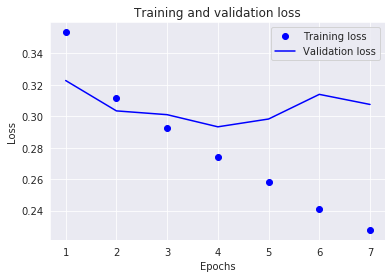

In [0]:
callbacks_list=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),keras.callbacks.ModelCheckpoint(filepath='paral_model.h5',monitor='val_loss',save_best_only=True)]
# Fit the model
history = paral_model.fit(X_train, y_train, validation_split=0.33, epochs=20, batch_size=20,callbacks=callbacks_list)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

No handles with labels found to put in legend.


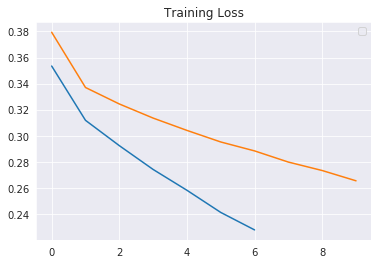

No handles with labels found to put in legend.


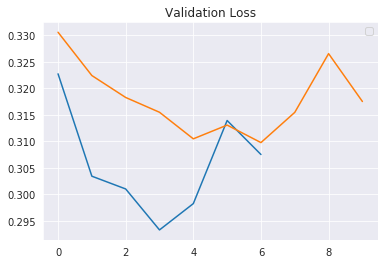

In [0]:
sns.set_style("darkgrid")
plt.plot(paral_model.history.history['loss'])
plt.plot(seq_model.history.history['loss'])
plt.title('Training Loss')
plt.legend()
plt.show()

sns.set_style("darkgrid")
plt.plot(paral_model.history.history['val_loss'])
plt.plot(seq_model.history.history['val_loss'])
plt.title('Validation Loss')
plt.legend()
plt.show()

In [0]:
## draw roc auc here
# Calculate outputs in test set
paral_model.load_weights('paral_model.h5')
paral_prob_test = paral_model.predict(X_test, verbose = 1)
paral_prob_train = paral_model.predict(X_train, verbose = 1)
paral_class_test = paral_model.predict_classes(X_test,verbose = 1)

67340/67340 [==============================] - 6s 85us/sample


In [0]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_train, paral_prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, paral_prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)


AUC train:  0.9553627887182262
AUC test:  0.9337086459579409


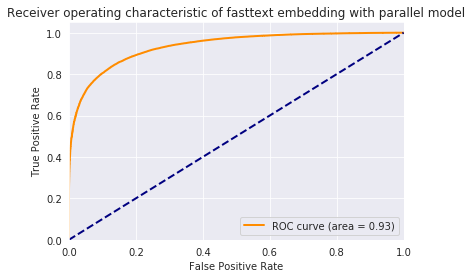

In [0]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of fasttext embedding with parallel model')
plt.legend(loc="lower right")
plt.show()

In [0]:
paral_class_test.shape

(43230, 1)

accuracy:0.8688892188892189,recall:0.9147082233672658,sensitivity:0.7572711501173589,precision:0.9017696739422223,f1:0.9081928688038766


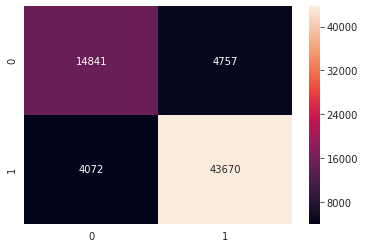

In [0]:
from sklearn.metrics import confusion_matrix
calc_metrics(confusion_matrix(y_test,paral_class_test))
conf_mat = pd.DataFrame(confusion_matrix(y_test,paral_class_test))
sns.heatmap(conf_mat,annot=True,fmt='d')

In [0]:
## see how words are different in top 20 from positive and negative sentiments. 
# perhaps remove most frequent words appear in both of them. 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df[df.sentiment == 0]['clean'])# get tokens from negative comments
neg_dict = pd.DataFrame(tokenizer.word_counts,columns=tokenizer.word_counts.keys(),index=[0])
neg_dict = neg_dict.T.reset_index()
neg_dict.columns=['word','count']

In [0]:
neg_dict.sort_index(by='count',ascending=False)[:50].reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


,index,word,count
0,19,received,9996
1,74,get,8544
2,50,still,8279
3,23,please,7644
4,46,one,6040
5,0,update,5971
6,223,refund,5958
7,162,would,5833
8,121,im,5492
9,163,like,5365


In [0]:
neg_dict.sort_index(by='count',ascending=False)[50:100].reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


,index,word,count
0,14,didnt,2481
1,217,well,2418
2,4110,app,2391
3,391,months,2380
4,146,mine,2355
5,312,new,2339
6,707,need,2319
7,550,delivery,2314
8,1178,updates,2281
9,219,people,2249


In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df[df.sentiment == 1]['clean'])# get tokens from negative comments
pos_dict = pd.DataFrame(tokenizer.word_counts,columns=tokenizer.word_counts.keys(),index=[0])
pos_dict = pos_dict.T.reset_index()
pos_dict.columns=['word','count']

In [0]:
pos_dict.sort_index(by='count',ascending=False)[:50].reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


,index,word,count
0,127,thanks,22894
1,25,get,15790
2,10,would,15222
3,53,hi,13934
4,118,thank,13863
5,15,update,13525
6,106,please,13063
7,154,im,12955
8,80,like,12607
9,398,one,12556


In [0]:
pos_dict.sort_index(by='count',ascending=False)[50:100].reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


,index,word,count
0,218,send,5063
1,973,ive,4952
2,41,looking,4936
3,583,back,4916
4,487,yet,4850
5,366,campaign,4803
6,840,think,4659
7,170,happy,4656
8,7,team,4654
9,94,last,4555


In [0]:
## try glove
!wget 'http://nlp.stanford.edu/data/glove.6B.zip'
!unzip glove.6B.zip

--2019-12-15 23:22:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-15 23:22:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-15 23:22:24--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
embeddings_index = {}
f=open('glove.6B.300d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['clean'])
data = pad_sequences(sequences, maxlen=150, padding = 'post') 
glove_embedding=np.zeros((len(word_index)+1,300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        glove_embedding[i] = embedding_vector
glove_embedding

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04656   ,  0.21318001, -0.0074364 , ...,  0.0090611 ,
        -0.20988999,  0.053913  ],
       [-0.25756001, -0.057132  , -0.67189997, ..., -0.16043   ,
         0.046744  , -0.070621  ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [0]:
glove_embedding.shape

(113220, 300)

In [0]:
glove_seq_model = Sequential()
embedding_layer = Embedding(glove_embedding.shape[0], 300,weights=[glove_embedding],input_length=150,trainable=False)            

glove_seq_model.add(embedding_layer)
glove_seq_model.add(Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu',strides=1))
glove_seq_model.add(Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu',strides=1))
glove_seq_model.add(Dropout(0.5))
glove_seq_model.add(MaxPooling1D(pool_size = 3))
glove_seq_model.add(Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu',strides=1))
glove_seq_model.add(Conv1D(filters=128,kernel_size=3,padding='valid',activation='relu',strides=1))
glove_seq_model.add(Dropout(0.5))
glove_seq_model.add(MaxPooling1D(pool_size = 3))
# Turn output matrices into 1D tensor for shallow network.
glove_seq_model.add(Flatten())
glove_seq_model.add(Dense(128, activation = 'relu'))
glove_seq_model.add(Dropout(0.5))
glove_seq_model.add(Dense(1, activation = 'sigmoid'))
glove_seq_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
callbacks_list=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),keras.callbacks.ModelCheckpoint(filepath='glove_seq_model.h5',monitor='val_loss',save_best_only=True)]


Train on 91601 samples, validate on 45117 samples
Epoch 1/20
91601/91601 [==============================] - 31s 341us/sample - loss: 0.4074 - acc: 0.8132 - val_loss: 0.3826 - val_acc: 0.8410
Epoch 2/20
91601/91601 [==============================] - 30s 332us/sample - loss: 0.3515 - acc: 0.8439 - val_loss: 0.3611 - val_acc: 0.8507
Epoch 3/20
91601/91601 [==============================] - 30s 328us/sample - loss: 0.3297 - acc: 0.8548 - val_loss: 0.3519 - val_acc: 0.8513
Epoch 4/20
91601/91601 [==============================] - 30s 327us/sample - loss: 0.3159 - acc: 0.8617 - val_loss: 0.3342 - val_acc: 0.8524
Epoch 5/20
91601/91601 [==============================] - 30s 324us/sample - loss: 0.3021 - acc: 0.8693 - val_loss: 0.4107 - val_acc: 0.8175
Epoch 6/20
91601/91601 [==============================] - 30s 325us/sample - loss: 0.2895 - acc: 0.8748 - val_loss: 0.3342 - val_acc: 0.8514
Epoch 7/20
91601/91601 [==============================] - 30s 325us/sample - loss: 0.2775 - acc: 0.8823 

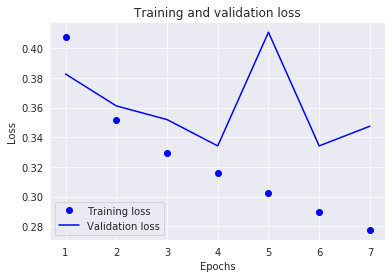

In [0]:
# Fit the model
history = glove_seq_model.fit(X_train, y_train, validation_split=0.33, epochs=20, batch_size=20,callbacks=callbacks_list)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
## draw roc auc here
# Calculate outputs in test set
glove_seq_model.load_weights("glove_seq_model.h5")
glove_seq_prob_test = glove_seq_model.predict(X_test, verbose = 1)
glove_seq_prob_train = glove_seq_model.predict(X_train, verbose = 1)


136718/136718 [==============================] - 8s 61us/sample


In [0]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_train, glove_seq_prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, glove_seq_prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)


AUC train:  0.9379772180889938
AUC test:  0.9161920585503787


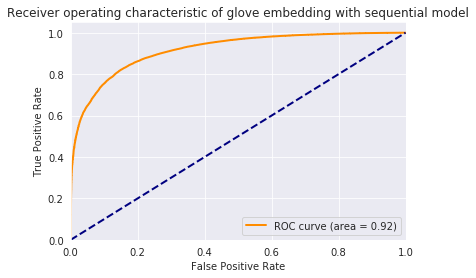

In [0]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of glove embedding with sequential model')
plt.legend(loc="lower right")
plt.show()

accuracy:0.8514256014256014,recall:0.915713627414017,sensitivity:0.6948157975303603,precision:0.8796555262681341,f1:0.8973224823226363


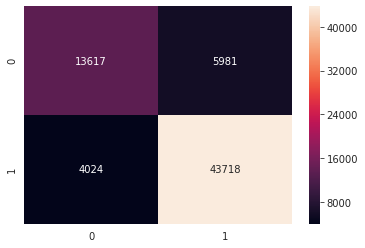

In [0]:
glove_seq_class_test=glove_seq_model.predict_classes(X_test)
conf_mat = pd.DataFrame(confusion_matrix(y_test, glove_seq_class_test))
calc_metrics(confusion_matrix(y_test, glove_seq_class_test))
sns.heatmap(conf_mat,annot=True,fmt='d')

In [0]:
glove_paral_model = Sequential()
embedding_layer = Embedding(len(glove_embedding),300,weights=[glove_embedding],input_length=150,trainable=False)               

glove_paral_model.add(embedding_layer)

# Now we add our graph model
glove_paral_model.add(paral)

# Add a few layers
glove_paral_model.add(Dense(128, activation='relu'))
glove_paral_model.add(Dropout(0.5))
glove_paral_model.add(Dense(1, activation='sigmoid'))

glove_paral_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

Train on 91601 samples, validate on 45117 samples
Epoch 1/20
91601/91601 [==============================] - 36s 388us/sample - loss: 0.4345 - acc: 0.7915 - val_loss: 0.3671 - val_acc: 0.8430
Epoch 2/20
91601/91601 [==============================] - 35s 377us/sample - loss: 0.3569 - acc: 0.8382 - val_loss: 0.3456 - val_acc: 0.8430
Epoch 3/20
91601/91601 [==============================] - 34s 376us/sample - loss: 0.3322 - acc: 0.8519 - val_loss: 0.3375 - val_acc: 0.8508
Epoch 4/20
91601/91601 [==============================] - 34s 373us/sample - loss: 0.3057 - acc: 0.8643 - val_loss: 0.3297 - val_acc: 0.8526
Epoch 5/20
91601/91601 [==============================] - 34s 370us/sample - loss: 0.2850 - acc: 0.8739 - val_loss: 0.3387 - val_acc: 0.8498
Epoch 6/20
91601/91601 [==============================] - 34s 368us/sample - loss: 0.2667 - acc: 0.8836 - val_loss: 0.3365 - val_acc: 0.8508
Epoch 7/20
91601/91601 [==============================] - 34s 371us/sample - loss: 0.2492 - acc: 0.8920 

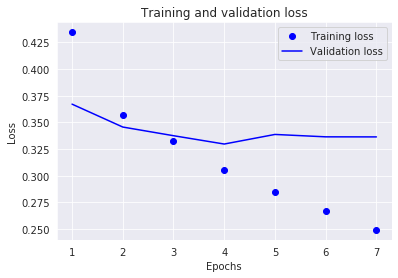

In [0]:
# Fit the model
callbacks_list=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),keras.callbacks.ModelCheckpoint(filepath='glove_paral_model.h5',monitor='val_loss',save_best_only=True)]
# Fit the model
history = glove_paral_model.fit(X_train, y_train, validation_split=0.33, epochs=20, batch_size=20,callbacks=callbacks_list)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

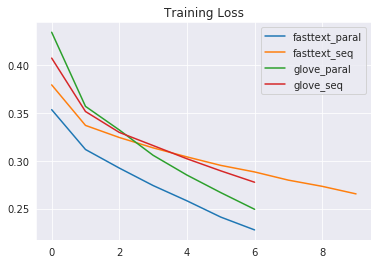

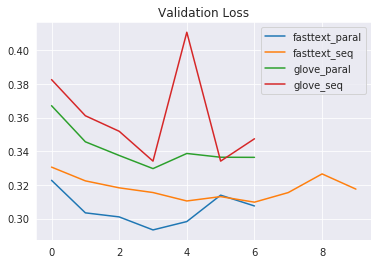

In [0]:
sns.set_style("darkgrid")
plt.plot(paral_model.history.history['loss'],label='fasttext_paral')
plt.plot(seq_model.history.history['loss'],label='fasttext_seq')
plt.plot(glove_paral_model.history.history['loss'],label='glove_paral')
plt.plot(glove_seq_model.history.history['loss'],label='glove_seq')
plt.title('Training Loss')
plt.legend()
plt.show()

sns.set_style("darkgrid")
plt.plot(paral_model.history.history['val_loss'],label='fasttext_paral')
plt.plot(seq_model.history.history['val_loss'],label='fasttext_seq')
plt.plot(glove_paral_model.history.history['val_loss'],label='glove_paral')
plt.plot(glove_seq_model.history.history['val_loss'],label='glove_seq')
plt.title('Validation Loss')
plt.legend()
plt.show()

In [0]:
## draw roc auc here
# Calculate outputs in test set
glove_paral_model.load_weights("glove_paral_model.h5")
glove_paral_prob_test = glove_paral_model.predict(X_test, verbose = 1)
glove_paral_prob_train = glove_paral_model.predict(X_train, verbose = 1)


136718/136718 [==============================] - 12s 88us/sample


In [0]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_train, glove_seq_prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, glove_seq_prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)


AUC train:  0.9379772180889938
AUC test:  0.9161920585503787


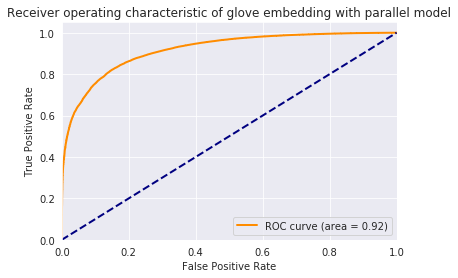

In [0]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of glove embedding with parallel model')
plt.legend(loc="lower right")
plt.show()

accuracy:0.8494356994356994,recall:0.8885677181517322,sensitivity:0.7541075619961221,precision:0.8979911517537732,f1:0.8932545823989556


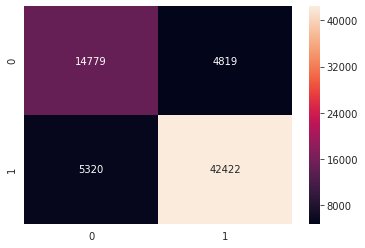

In [0]:
glove_paral_class_test=glove_paral_model.predict_classes(X_test)
calc_metrics(confusion_matrix(y_test, glove_paral_class_test))
conf_mat = pd.DataFrame(confusion_matrix(y_test, glove_paral_class_test))
sns.heatmap(conf_mat,annot=True,fmt='d')